### This code:
        1. imports REMA tiles, calculates the drainage basins and depression depths
        2. import Landsat 8 images that overlap the REMA tiles, and extracts surface lake boundaries
        3. Combines these two products and calculates the percentage of lakes observed in optical imagery vs. predicted from REMA 

In [2]:
from dask.distributed import Client
from dask.diagnostics import ProgressBar
import numpy as np
import xarray as xr
import pandas as pd
import hvplot.xarray
from matplotlib import widgets
from matplotlib import pyplot as plt
#from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
%matplotlib inline
import skimage.morphology
import skimage.segmentation
#import richdem as rd
import scipy.ndimage
import dask
import math
import scipy.sparse
import geopandas as gpd

from matplotlib import widgets

import dask.array as da

from skimage import data, io

import cartopy.crs as ccrs

import landlab
from landlab.utils import watershed
from landlab.components import FlowAccumulator, DepressionFinderAndRouter
from landlab.plot import imshow_grid
from landlab import RasterModelGrid


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


In [1]:
conda install landlab

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - landlab


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    black-19.10b0              |             py_4          83 KB  conda-forge
    bmipy-2.0                  |             py_0          11 KB  conda-forge
    landlab-2.1.1              |   py37h03ebfcd_0         2.1 MB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    pathspec-0.8.0             |     pyh9f0ad1d_0          28 KB  conda-forge
    patsy-0.5.1                |             py_0         187 KB  conda-forge
    regex-2020.7.14            |   py37h8f50634_0         352 KB  conda-forge
   

In [3]:
def factorization(n):

    factors = []

    def get_factor(n):
        x_fixed = 2
        cycle_size = 2
        x = 2
        factor = 1

        while factor == 1:
            for count in range(cycle_size):
                if factor > 1: break
                x = (x * x + 1) % n
                factor = np.gcd(x - x_fixed, n)

            cycle_size *= 2
            x_fixed = x

        return factor

    while n > 1:
        next = get_factor(n)
        factors.append(next)
        n //= next

    return factors

# Import melt mask created from Landsat 8:

In [2]:
Amery_meltmask = xr.open_dataarray('Amery_mask.nc')

# Part 1: REMA DEM drainage basins

## Import REMA tile from google bucket

In [160]:
uri_fmt = 'https://storage.googleapis.com/pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

chunksize = 8 * 512
rows = []
for i in tqdm(range(38, 36, -1)): #this tile range is Amery Ice Shelf
    cols = []
    for j in range(47, 53):
        uri = uri_fmt.format(i_idx=i, j_idx=j)
        try:
            dset = xr.open_rasterio(uri, chunks=chunksize)
            dset_masked = dset.where(dset > 0.0)
            cols.append(dset_masked)
            #print(uri)
        except RasterioIOError:
            pass
    rows.append(cols)

In [161]:
dsets_rows = [xr.concat(row, 'x') for row in rows]
ds = xr.concat(dsets_rows, 'y', )
ds.data

dask.array<concatenate, shape=(1, 25000, 75000), dtype=float32, chunksize=(1, 4096, 4096), chunktype=numpy.ndarray>

In [162]:
ds_array = ds.squeeze()
ds_array.data

dask.array<getitem, shape=(25000, 75000), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>

In [163]:
x_sum = Amery_meltmask.sum(dim='y')

 ...]

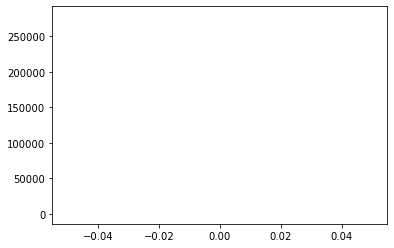

In [164]:
plt.plot(x_sum)

In [9]:
#max_melt_extent = np.max(np.where(x_sum>np.mean(x_sum)))
max_melt_extent = np.argmax(x_sum)

In [11]:
#max_melt_extent = np.argmax(y_sum)
x_lim = float(Amery_meltmask.x[max_melt_extent])

In [12]:
x_lim

1906905.3868601625

In [13]:
x_max = Amery_meltmask.x.max()
x_min = Amery_meltmask.x.min()

In [14]:
y_sum = Amery_meltmask.sum(dim='x')

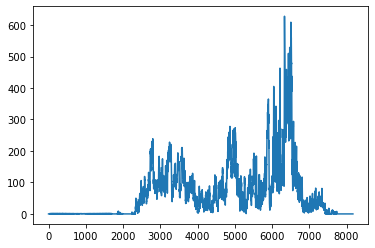

In [15]:
plt.plot(y_sum)

In [16]:
#max_melt_extent = np.argmax(y_sum)
max_melt_y = np.max(np.nonzero(y_sum.values))

In [17]:
y_lim = Amery_meltmask.y[max_melt_y]

In [38]:
ds_array_subset

<xarray.DataArray (y: 25000, x: 74000)>
dask.array<getitem, shape=(25000, 74000), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
    band     int64 1
  * x        (x) float64 1.6e+06 1.6e+06 1.6e+06 ... 2.192e+06 2.192e+06
  * y        (y) float64 8e+05 8e+05 8e+05 8e+05 ... 6e+05 6e+05 6e+05 6e+05

In [39]:
factorization(ds_array_subset.y.size-2)

[2, 29, 431]

In [40]:
factorization(ds_array_subset.x.size-3)

[217, 31, 11]

In [165]:
ds_array_rs = ds_array.coarsen(x=40,y=40).mean()

### The following is a number of functions from LandLab to calculate drainage catchements from a DEM:

In [166]:
with ProgressBar():
    dem  = ds_array_rs.values


[###                                     ] | 8% Completed |  1min 30.4s

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[##########                              ] | 26% Completed |  3min 37.0s

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 12min  8.7s


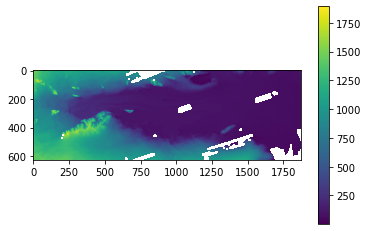

In [167]:
plt.imshow(dem)
plt.colorbar()

In [168]:
dem = dem[:,:1000]

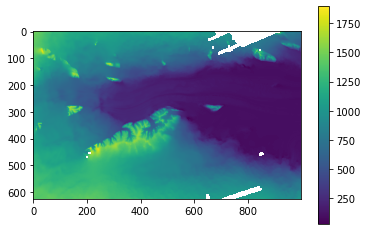

In [169]:
plt.imshow(dem)
plt.colorbar()

In [175]:
def HypsometryofAllBasins(dem):
    mg = RasterModelGrid(dem.shape)
    z = mg.add_field("topographic__elevation", np.float_(dem.ravel()), at="node", units="m", copy=True, clobber=False)
    mg.set_status_at_node_on_edges(right=mg.BC_NODE_IS_FIXED_VALUE,
                               top=mg.BC_NODE_IS_CLOSED,
                               left=mg.BC_NODE_IS_FIXED_GRADIENT,
                               bottom=mg.BC_NODE_IS_CLOSED)
    #df = DepressionFinderAndRouter(mg, routing='D8',reroute_flow=True)
    fa = FlowAccumulator(mg,
                     flow_director='D8',
                    depression_finder = DepressionFinderAndRouter
                    )
    fa.accumulate_flow()
    ws = watershed.get_watershed_masks(mg)
    DB = skimage.morphology.label(ws.reshape(dem.shape))
    P_all = fa.depression_finder.depression_depth.reshape(dem.shape)
    mg2 =  mg

    fa2 = FlowAccumulator(mg2,
                     flow_director='D8')


    fa2.accumulate_flow()

    ws_nowater =  watershed.get_watershed_masks(mg2)
    DB_nowater = ws_nowater.reshape(dem.shape)
    cellArea = np.mean(np.float_(ds_array_rs.x[1:-1])-np.float_(ds_array_rs.x[0:-2]))*np.mean(np.float_(ds_array_rs.y[0:-2])-np.float_(ds_array_rs.y[1:-1]))

    #Build  data structure  on each drainage Catchments
    b_dict = {'SubCatchmentNumbers','SubCatchmentAreas','SubCatchmentVolumes','SubCatchmentMeanElev','CatchmentNumber','CatchmentArea','MaskLogical','MaskI','MaskXY','skip','Volume','maxdepth','hw','h'}
    b = pd.DataFrame(data={},columns=b_dict)
    histcount = np.bincount(DB.ravel())
    main_catchments = np.argwhere(histcount>=100)
    for kk in main_catchments:
        CatchmentNumber = kk;
        Mask = DB == kk; 
        SubCatchmentNumbers  = np.unique((DB_nowater[Mask]).ravel())
        SubCatchmentNumbers =  SubCatchmentNumbers[1:-1]
        subset = DB_nowater[Mask]
        [SubCatchmentPixelN, bins]=np.histogram(subset, bins=(np.unique(subset)))
        SubCatchmentAreas = SubCatchmentPixelN*cellArea
        counter=0
        SubCatchmentVolumes = np.zeros((len(SubCatchmentNumbers),1))
        SubCatchmentMeanElev = np.zeros((len(SubCatchmentNumbers),1))
        for jj in SubCatchmentNumbers:
            SubCatchmentMask =  DB_nowater == jj
            SubCatchmentMaskXY = np.where(SubCatchmentMask)
            SubCatchmentVolumes[counter] = np.sum((P_all[SubCatchmentMaskXY]).ravel()) * cellArea
            SubCatchmentMeanElev[counter] = np.mean((dem[SubCatchmentMaskXY]).ravel())
            counter = counter+1

        CatchmentArea = (np.sum(np.int_(Mask.ravel()))*cellArea); # basin area in m^2
        MaskLogical = Mask;
        MaskXY = np.where(Mask);  # mask for the basin
        MaskI= np.ravel_multi_index(MaskXY,dem.shape)
        depths = P_all[MaskXY] #Water accomodation space in drainage basin
        if np.count_nonzero(depths>0)<1: #If accomodation space is demero, i.e, no nondemero depths
            skip = 1;
            h = 0;
            maxdepth = 0;
            Volume = 0;
            hw = np.zeros(depths.size)
            #continue
        else:
            valid = np.argwhere(depths>=0)
            depths = depths[valid];
            heights = np.max(depths) - depths; #potential water height from bottom
            skip = 0;        
            Volume = (np.sum(depths.ravel())*cellArea);
            heights_sorted = np.sort(heights);
            while len(np.argwhere(np.diff(heights_sorted)==0))>0: #remove all identical pixels
                I = np.argwhere(np.diff(heights_sorted)==0);
                heights_sorted[I+1] = heights_sorted[I+1] +0.0001; # nudge the similar values up a tiny amount to avoid issues with the interpolation
            hw = heights_sorted;   # heights for hypsometry
            maxdepth = np.max(depths); # not actually the same as max(Heights) the smallest value of depths is not equal to demero
            h = 0;   # initial water depth is demero
        data={'CatchmentNumber':CatchmentNumber,
               'CatchmentArea':CatchmentArea,
               'MaskLogical':MaskLogical.ravel(),
               'MaskI':MaskI,
                'MaskXY': MaskXY,
               'skip':skip,
               'Volume':Volume,
               'maxdepth':maxdepth,
               'hw':hw,
               'h':h,
                'SubCatchmentNumbers':  SubCatchmentNumbers,
             'SubCatchmentAreas': SubCatchmentAreas,
             'SubCatchmentVolumes': SubCatchmentVolumes,
             'SubCatchmentMeanElev': SubCatchmentMeanElev}
        DrainageBasin = pd.Series(data)
        b = b.append(DrainageBasin, ignore_index=True)

    return b, DB,DB_nowater, P_all;

In [176]:
b, DB, DB_nowater, P_all = HypsometryofAllBasins(dem)

/srv/conda/envs/notebook/lib/python3.7/site-packages/landlab/components/depression_finder/lake_mapper.py:622: RuntimeWarning: invalid value encountered in less
  not_too_high = self._elev[nbrs] < self._elev[the_node]
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater_equal


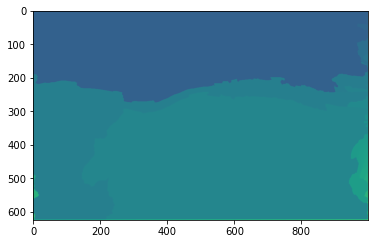

In [177]:
plt.imshow(DB)

In [18]:
REMA_ds = xr.Dataset(
    {
    "REMA_basins":(
    ('y','x'),
    DB),
    "REMA_subbasins":(
    ('y','x'),
    DB_nowater),
    "depression_depths":(
    ('y','x'),
     P_all),
    "elevation":(
    ('y','x'),
     dem)
    }, coords = {'x': ds_array_rs.x[0:1000], 'y': ds_array_rs.y},
    attrs   = ds_array_rs.attrs)

In [19]:
REMA_ds.to_netcdf('REMA_subset.nc')

In [178]:
b.to_json('REMA_subset_dict.json')

# Part 2: Landsat 8 derived surface lake boundaries:

# Part 3: Combine the two xarray DataSets and calculate statistics of how they match up

In [3]:
Amery_meltmask = xr.open_rasterio('LC08_L1GT_128111_20150129_20170413_01_T2_AverageB4B8_depth.tif',parse_coordinates=True)

In [4]:
REMA_ds = xr.open_dataset('REMA_subset.nc')

In [5]:
import json

In [6]:
with open('REMA_subset_dict.json') as f:
  b = json.load(f)

In [7]:
b = pd.DataFrame(b)

In [8]:
REMA_bounds = np.array([[REMA_ds.x.min(), REMA_ds.x.max(), REMA_ds.x.max(),REMA_ds.x.min()],[REMA_ds.y.min(),REMA_ds.y.min(),REMA_ds.y.max(),REMA_ds.y.max()]])
L8_bounds = np.array([[Amery_meltmask.x.min(), Amery_meltmask.x.max(), Amery_meltmask.x.max(),Amery_meltmask.x.min()],[Amery_meltmask.y.min(),Amery_meltmask.y.min(),Amery_meltmask.y.max(),Amery_meltmask.y.max()]])


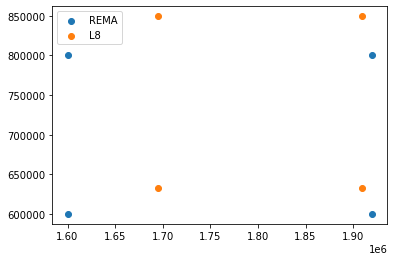

In [9]:
plt.figure()
plt.scatter(REMA_bounds[0],REMA_bounds[1])
plt.scatter(L8_bounds[0],L8_bounds[1])
plt.legend(['REMA','L8'])

In [10]:
Amery_meltmask

<xarray.DataArray (band: 1, y: 7231, x: 7141)>
[51636571 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 8.493e+05 8.493e+05 8.492e+05 ... 6.324e+05 6.324e+05
  * x        (x) float64 1.695e+06 1.695e+06 1.695e+06 ... 1.909e+06 1.909e+06
Attributes:
    transform:         (30.0, 0.0, 1694685.0, 0.0, -30.0, 849315.0)
    crs:               +init=epsg:3031
    res:               (30.0, 30.0)
    is_tiled:          1
    nodatavals:        (nan,)
    scales:            (1.0,)
    offsets:           (0.0,)
    AREA_OR_POINT:     Point
    TIFFTAG_SOFTWARE:  MATLAB 9.7, Mapping Toolbox 4.9

In [11]:
overlap_xstart = np.argwhere(REMA_ds.x.values>Amery_meltmask.x.values.min()).min()
overlap_xend = np.argwhere(REMA_ds.x.values<Amery_meltmask.x.values.max()).max()

overlap_yend = np.argwhere(REMA_ds.y.values>Amery_meltmask.y.values.min()).max()
overlap_ystart = np.argwhere(Amery_meltmask.y.values<REMA_ds.y.values.max()).min()

REMA_overlap = REMA_ds.isel(x=slice(overlap_xstart,overlap_xend),y=slice(0,overlap_yend))
L8_overlap = Amery_meltmask.isel(x=slice(0,-1), y=slice(overlap_ystart,-1))

In [12]:
overlap_ystart

1649

In [13]:
REMA_bounds = np.array([[REMA_overlap.x.min(), REMA_overlap.x.max(), REMA_overlap.x.max(),REMA_overlap.x.min()],[REMA_overlap.y.min(),REMA_overlap.y.min(),REMA_overlap.y.max(),REMA_overlap.y.max()]])
L8_bounds = np.array([[L8_overlap.x.min(), L8_overlap.x.max(), L8_overlap.x.max(),L8_overlap.x.min()],[L8_overlap.y.min(),L8_overlap.y.min(),L8_overlap.y.max(),L8_overlap.y.max()]])


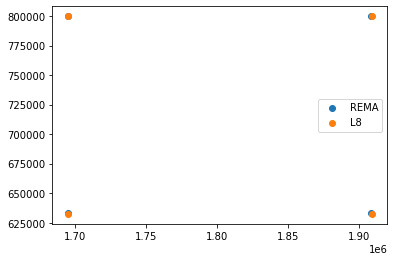

In [14]:
plt.figure()
plt.scatter(REMA_bounds[0],REMA_bounds[1])
plt.scatter(L8_bounds[0],L8_bounds[1])
plt.legend(['REMA','L8'])

In [15]:
L8_overlap = L8_overlap[0].interp(coords={'x':REMA_overlap.REMA_basins.x,'y':REMA_overlap.REMA_basins.y})

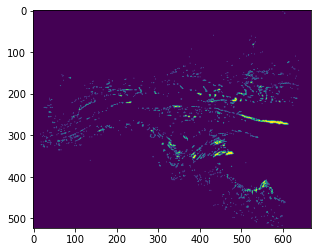

In [16]:
plt.imshow(L8_overlap>0)

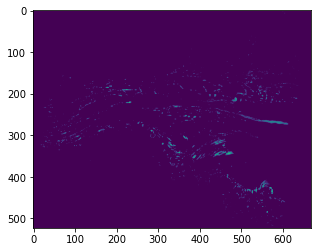

In [17]:
plt.imshow(L8_overlap.values, vmax=2000)

In [18]:
LakeData = xr.Dataset(
    {
    "REMA_basins":(
    ('y','x'),
    REMA_overlap.REMA_basins),
    "REMA_subbasins":(
    ('y','x'),
    REMA_overlap.REMA_subbasins),
    "depression_depths":(
    ('y','x'),
     REMA_overlap.depression_depths),
    "elevation":(
    ('y','x'),
     REMA_overlap.elevation),
    "L8_lakes":(
    ('y','x'),L8_overlap)
    }, coords = {'x': REMA_overlap.x, 'y': REMA_overlap.y},
    attrs   = REMA_overlap.attrs)

In [19]:
LakeData

<xarray.Dataset>
Dimensions:            (x: 668, y: 523)
Coordinates:
    band               int64 1
  * x                  (x) float64 1.695e+06 1.695e+06 ... 1.908e+06 1.908e+06
  * y                  (y) float64 7.998e+05 7.995e+05 ... 6.331e+05 6.328e+05
Data variables:
    REMA_basins        (y, x) int64 296 297 298 299 300 ... 1804 1804 1804 1804
    REMA_subbasins     (y, x) int64 296 297 298 299 ... 510965 504970 504970
    depression_depths  (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    elevation          (y, x) float32 1144.11 1143.1 1142.15 ... 474.266 458.413
    L8_lakes           (y, x) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0

In [20]:
LakeData = LakeData.assign(REMALake = LakeData.depression_depths>0)

In [21]:
overlap = float((np.bool_(LakeData.L8_lakes) & LakeData.REMALake).sum())
rema_basins  = float(LakeData.REMALake.sum())
L8_lakes  = float((LakeData.L8_lakes>0).sum())

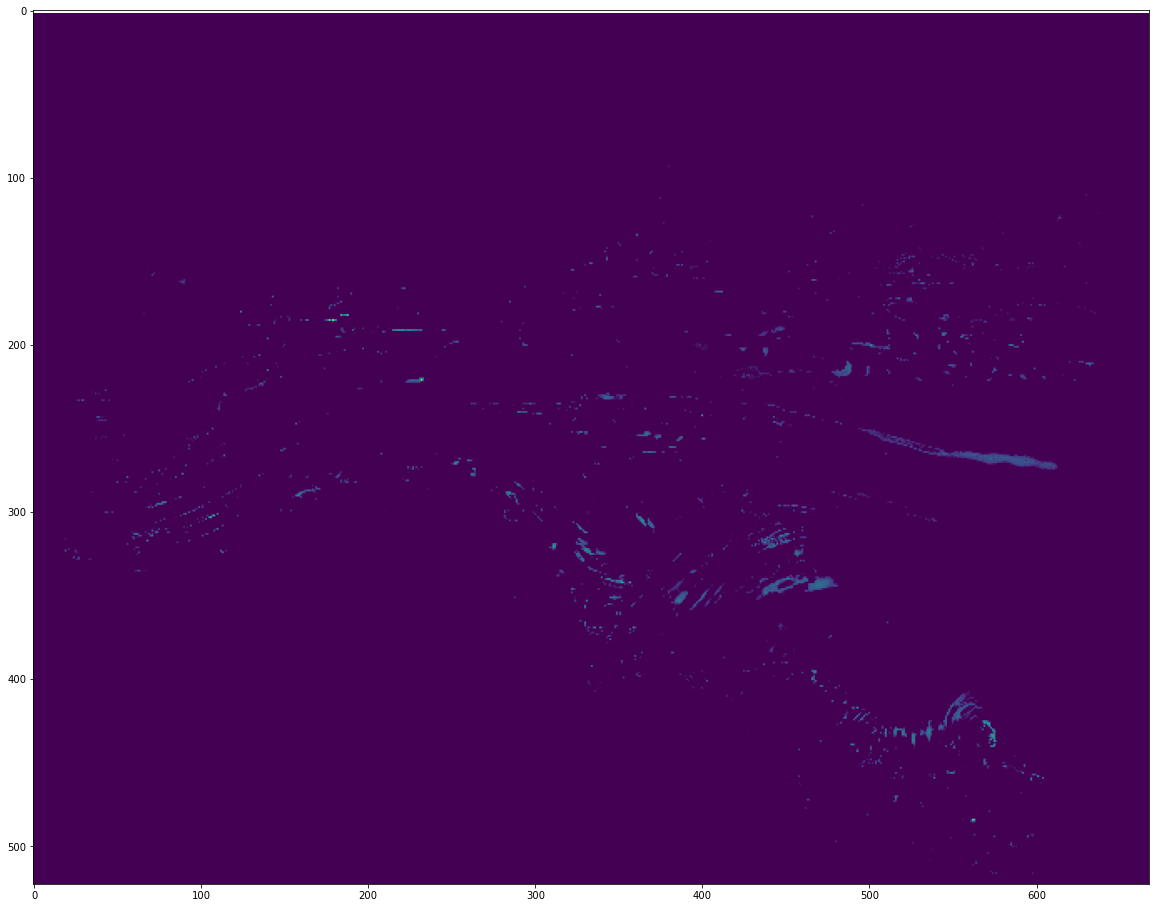

In [22]:
plt.figure(figsize=(20,20))
plt.imshow(LakeData.L8_lakes*LakeData.REMALake)

In [23]:
L8_lakes

4945.0

In [24]:
overlap/(rema_basins-overlap)

0.07320231566118221

In [25]:
overlap/(L8_lakes)

0.777350859453994

In [26]:
overlap

3844.0

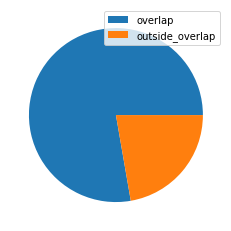

In [27]:
plt.pie([overlap,L8_lakes-overlap])
plt.legend(['overlap','outside_overlap'])

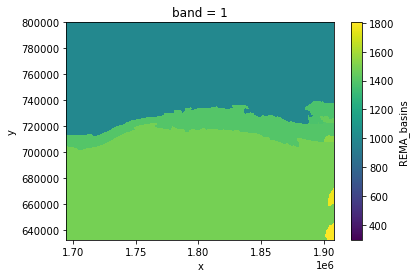

In [28]:
LakeData.REMA_basins.plot()

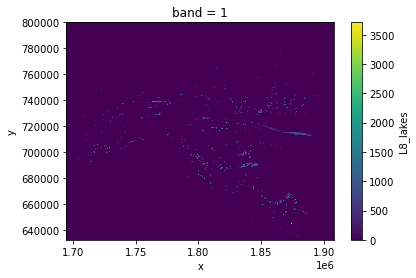

In [29]:
LakeData.L8_lakes.plot()

In [48]:
#Determining water depth from lake rim elevation
L8_lake_mask = LakeData.L8_lakes.values>10
labelled_lakes = skimage.morphology.label(L8_lake_mask,background=0,connectivity=2)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


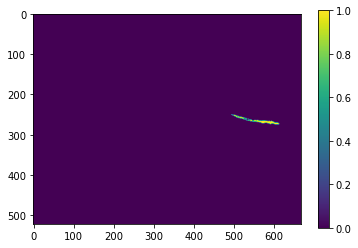

In [102]:
plt.imshow(labelled_lakes==578)
plt.colorbar()

In [206]:
L8_b = pd.DataFrame(columns={'LakeLabel','LakeMask','PixelElevation','RimElevations', 'MeanRim','MinRim','MaxRim','PixelWaterDepths'}) 
dem = LakeData.elevation.values
rim_waterdepths_max = np.zeros(labelled_lakes.shape)
rim_waterdepths_mean  = np.zeros(labelled_lakes.shape)
num_lakes = max(labelled_lakes.ravel())
for j in np.arange(1,num_lakes):
    Lake = labelled_lakes == j
    PixelElevations = dem[Lake]
    if len(PixelElevations)>3:
        rimpixels = skimage.segmentation.find_boundaries(Lake,mode='inner')
        RimElevations = dem[rimpixels]
        MeanRim = np.mean(RimElevations)
        MinRim = np.min(RimElevations)
        MaxRim = np.max(RimElevations)
        PixelWaterDepths = -(PixelElevations-MeanRim)
        
        rim_waterdepths_mean[Lake] = PixelWaterDepths.ravel()
        rim_waterdepths_max[Lake] = (-(PixelElevations-MaxRim)).ravel()
        data={'LakeLabel':j,
                   'LakeMask':Lake,
                   'PixelElevation':PixelElevations,
                    'RimElevations':RimElevations,
                   'MeanRim':MeanRim,
                    'MinRim': MinRim,
                   'MaxRim':MaxRim,
                   'PixelWaterDepths':PixelWaterDepths
                    }
        LakeSeries = pd.Series(data)
        L8_b = L8_b.append(LakeSeries, ignore_index=True)

In [207]:
rim_waterdepths_max[rim_waterdepths_max>30]=0
rim_waterdepths_mean[rim_waterdepths_mean>30]=0

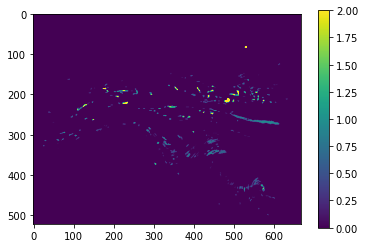

In [210]:
plt.imshow(rim_waterdepths_max-rim_waterdepths_mean, vmax=2)
plt.colorbar()

(0.0, 2000.0)

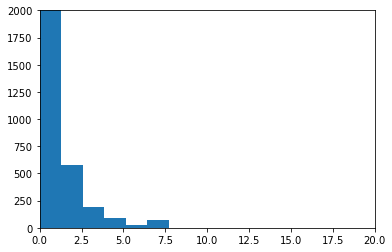

In [221]:
plt.hist((rim_waterdepths_max.ravel()-rim_waterdepths_mean.ravel()),200)
plt.xlim(0,20)
plt.ylim(0,2000)

(-5.0, 5.0)

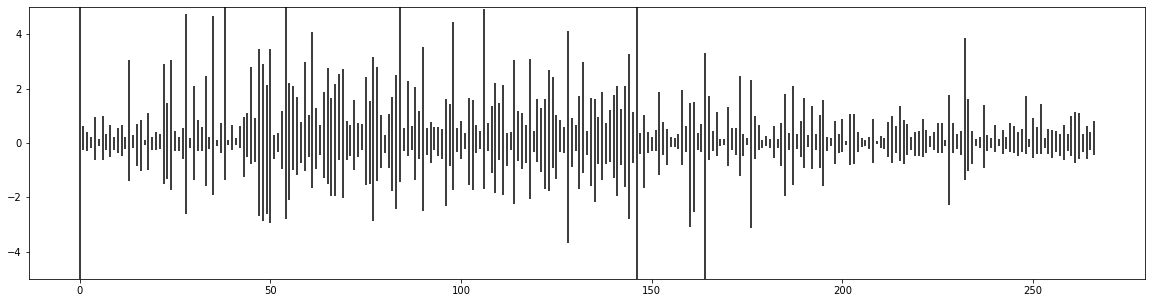

In [190]:
plt.figure(figsize=(20,5))
for lake in np.arange(0,len(L8_b)):
    RimElevations = L8_b.RimElevations[lake]
    plt.vlines(lake,np.min(RimElevations)-np.mean(RimElevations), np.max(RimElevations)-np.mean(RimElevations))
plt.ylim((-5,5))
    

In [192]:
L8_b.first

<bound method NDFrame.first of         MeanRim      MinRim  \
0    970.661621  756.919434   
1    115.898903  115.643753   
2    129.364563  129.084167   
3     97.230217   97.055481   
4     97.120720   96.489723   
..          ...         ...   
262  116.961441  116.357452   
263  238.195129  237.842194   
264  359.795074  359.189850   
265  265.534332  265.256226   
266  332.767700  332.313324   

                                              LakeMask  \
0    [[False, False, False, False, False, False, Fa...   
1    [[False, False, False, False, False, False, Fa...   
2    [[False, False, False, False, False, False, Fa...   
3    [[False, False, False, False, False, False, Fa...   
4    [[False, False, False, False, False, False, Fa...   
..                                                 ...   
262  [[False, False, False, False, False, False, Fa...   
263  [[False, False, False, False, False, False, Fa...   
264  [[False, False, False, False, False, False, Fa...   
265  [[False, Fa

In [150]:
numbasins = len(b)

In [151]:
percentfilled = np.zeros((LakeData.sizes['y'],LakeData.sizes['x']))
overlap = np.logical_and(LakeData.L8_lakes.values, LakeData.REMALake.values)
REMA_Lakes = LakeData.REMALake.values
L8_lakes = (LakeData.L8_lakes>0).values

In [152]:
for basinnum in np.arange(1,numbasins):
    kk = b.CatchmentNumber[basinnum]
    Mask = LakeData.REMA_basins.values == kk;
    overlap_masked = np.int_(overlap[Mask]).sum()
    rema_basins_masked  = np.int_(REMA_Lakes[Mask]).sum()
    L8_lakes_masked  = np.int_(L8_lakes[Mask]).sum()
    percentfilled[Mask] = overlap_masked/(rema_basins_masked-overlap_masked)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


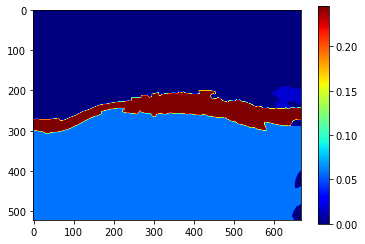

In [153]:
plt.imshow(percentfilled, cmap='jet')
plt.colorbar()

In [154]:
basin_ratio = np.zeros((LakeData.sizes['y'],LakeData.sizes['x']))
for basinnum in np.arange(1,numbasins):
    kk = b.CatchmentNumber[basinnum]
    Mask = LakeData.REMA_basins.values == kk;
    basin_ratio[Mask] = b.Volume[basinnum]/b.CatchmentArea[basinnum]

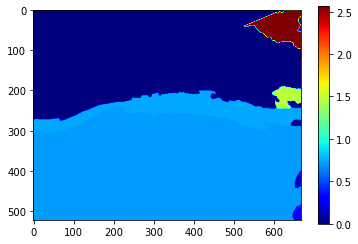

In [155]:
plt.imshow(basin_ratio, cmap='jet')
plt.colorbar()

In [156]:
#How far down the catchment has water accumulated?
#1. what is the lowest point that REMA speculates water to have reached?
#2. What is the lowest point that L8 lakes reach

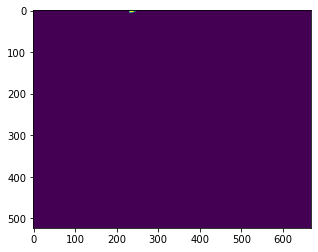

In [157]:
plt.imshow(LakeData.REMA_subbasins==1533)

In [158]:
dem = LakeData.elevation.values

catchment_lakeelevations = pd.DataFrame(data=[], columns=['LowestLakeElevations'])

for kk in np.arange(0,numbasins):
    subcatchments = b.SubCatchmentNumbers[kk]
    numberofsubcatch = len(subcatchments)
    lowest_L8_lakes = np.zeros((numberofsubcatch,1))

    for subcatchment_num in np.arange(0,numberofsubcatch):
        Mask = LakeData.REMA_subbasins.values==subcatchments[subcatchment_num]
        if len(dem[Mask & L8_lakes])>0:
            lowest_L8_lakes[subcatchment_num] = np.min(dem[Mask & L8_lakes])
        else:
            lowest_L8_lakes[subcatchment_num]= 0
    data  = {'LowestLakeElevations':lowest_L8_lakes}
    add_data =  pd.Series(data, name = str(kk))
    catchment_lakeelevations = catchment_lakeelevations.append(add_data)
    
    
    
    

In [159]:
b = b.merge(catchment_lakeelevations,left_index=True,right_index=True)

Text(0.5, 0, 'Lowest Lake Elevation ASL (m)')

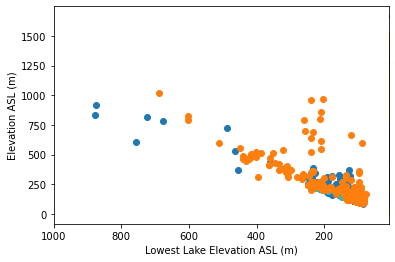

In [160]:
plt.figure()
for kk in np.arange(0,numbasins):
    if len(b.LowestLakeElevations[kk])>0:
        elevations = np.float_(np.array(b.SubCatchmentMeanElev[kk]))
        elevations = np.nan_to_num(elevations,-9999)
        sortI = np.argsort(elevations,0)
        lowest_L8_lakes = b.LowestLakeElevations[kk]
        sorted_L8_lakes = np.squeeze((lowest_L8_lakes[sortI]).tolist())
        if np.count_nonzero(elevations)>1:
            plt.scatter(sorted_L8_lakes,elevations[sortI])
        else:           
            plt.scatter(sorted_L8_lakes,elevations)
ax = plt.gca()
ax.invert_xaxis()
plt.xlim(1000,10)
plt.ylabel('Elevation ASL (m)')
plt.xlabel('Lowest Lake Elevation ASL (m)')


In [161]:
Map = np.zeros(LakeData.elevation.shape)
for kk in np.arange(0,numbasins):
    subcatchments = b.SubCatchmentNumbers[kk]
    numberofsubcatch = len(subcatchments)
    LowestLakeElevations = b.LowestLakeElevations[kk]
    for subcatchment_num in np.arange(0,numberofsubcatch):
        Mask = LakeData.REMA_subbasins.values==subcatchments[subcatchment_num]
        Map[Mask] =  LowestLakeElevations[subcatchment_num]

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


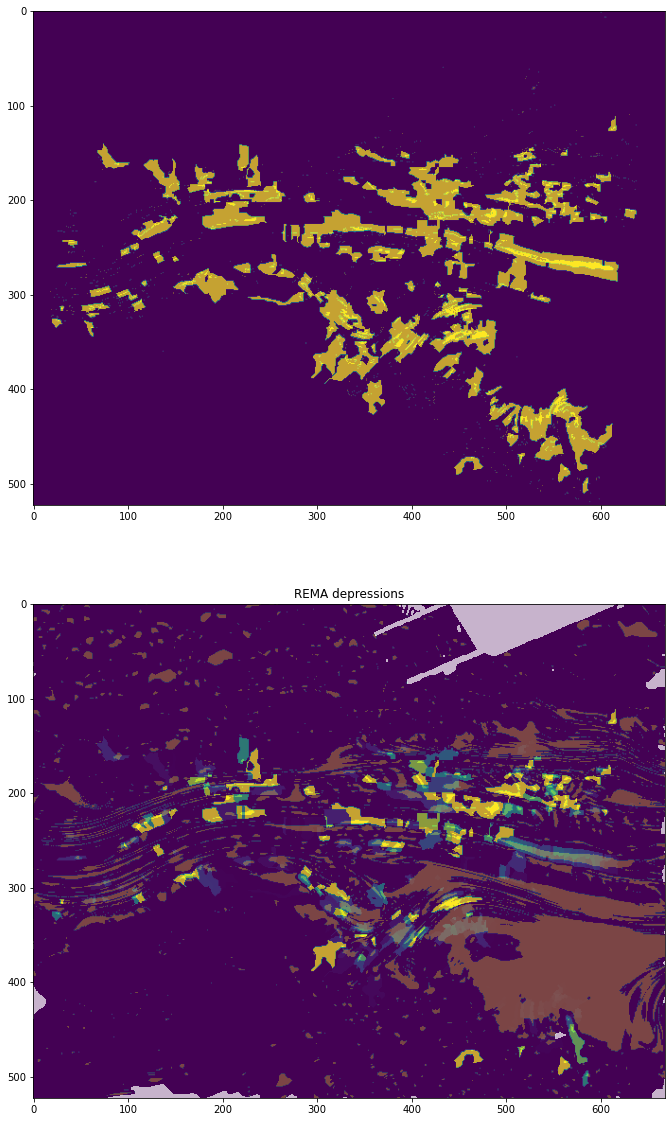

In [576]:
fig, ax = plt.subplots(nrows=2, figsize=(20,20))
plt.title('Landsat 8 lakes')
ax[0].imshow(Map>0)
ax[0].imshow(LakeData.L8_lakes>0,alpha=0.3)

ax[1].imshow(Map)
ax[1].imshow(LakeData.REMALake,alpha=0.3)
plt.title('REMA depressions');


1. How much water does REMA say L8 lakes have/
2. What percent "filled" is each subcatchment?
3. What percent filled is each catchment?

In [579]:
P_all = LakeData.depression_depths.values
catchment_lakefillvolume = pd.DataFrame(data=[], columns=['LakeFillPercent'])

for kk in np.arange(0,numbasins):
    subcatchments = b.SubCatchmentNumbers[kk]
    numberofsubcatch = len(subcatchments)
    LakeFillVolume = np.zeros((numberofsubcatch,1))
    LakeFillPercent = np.zeros((numberofsubcatch,1))

    for subcatchment_num in np.arange(0,numberofsubcatch):
        Mask = LakeData.REMA_subbasins.values==subcatchments[subcatchment_num]
        REMA_lakevolume = np.nansum(P_all[Mask])*30**2
        lakefillvol = np.nansum(rim_waterdepths[Mask]) *30**2
        LakeFillVolume[subcatchment_num] = lakefillvol

        LakeFillPercent[subcatchment_num]  = np.nan_to_num(lakefillvol)/np.nan_to_num(REMA_lakevolume)
    data  = {'LakeFillVolume':LakeFillVolume,
            'LakeFillPercent':np.nan_to_num(LakeFillPercent)}
    add_data =  pd.Series(data, name = str(kk))
    catchment_lakefillvolume = catchment_lakefillvolume.append(add_data)
    
    

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [582]:
b = b.merge(catchment_lakefillvolume,left_index=True,right_index=True)

In [583]:
Map = np.zeros(LakeData.elevation.shape)
for kk in np.arange(0,numbasins):
    subcatchments = b.SubCatchmentNumbers[kk]
    numberofsubcatch = len(subcatchments)
    LakeFillPercent = b.LakeFillPercent[kk]
    for subcatchment_num in np.arange(0,numberofsubcatch):
        Mask = LakeData.REMA_subbasins.values==subcatchments[subcatchment_num]
        Map[Mask] =  LakeFillPercent[subcatchment_num]

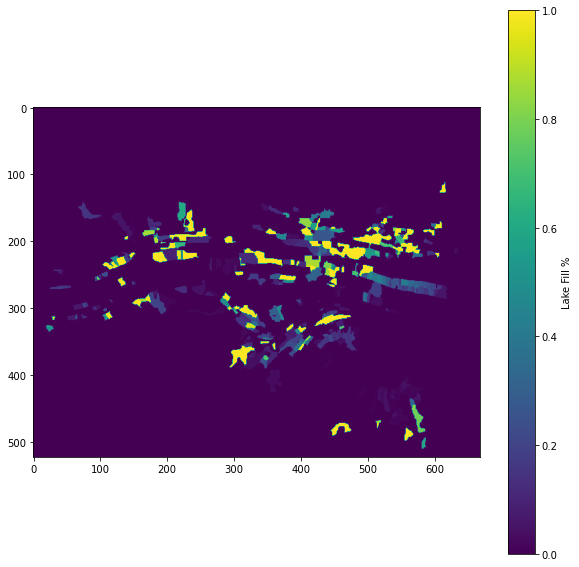

In [584]:
Map[Map>1] = 1
plt.figure(figsize=(10,10))
plt.imshow(Map)
cbar = plt.colorbar(label='Lake Fill %')


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


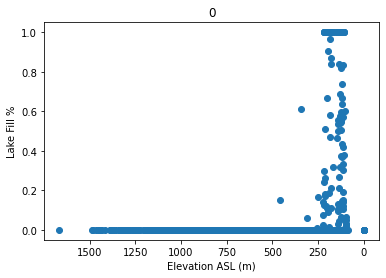

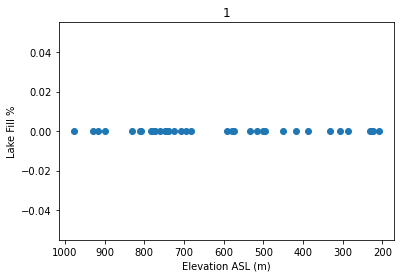

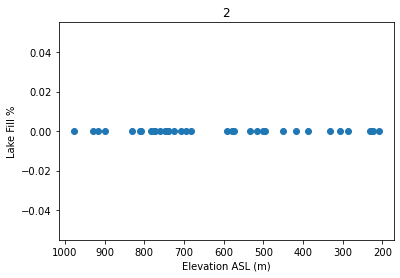

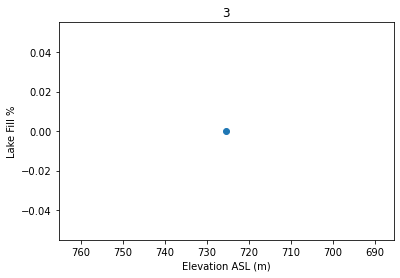

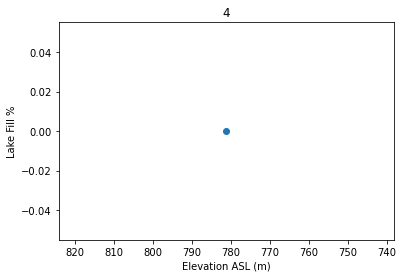

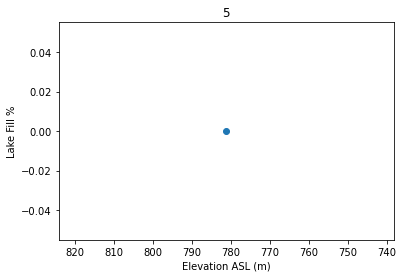

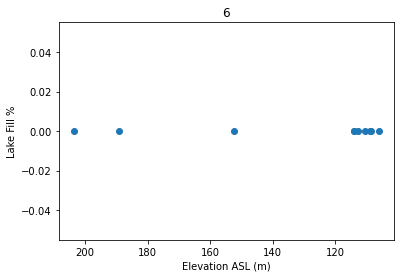

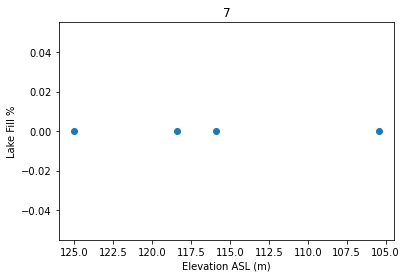

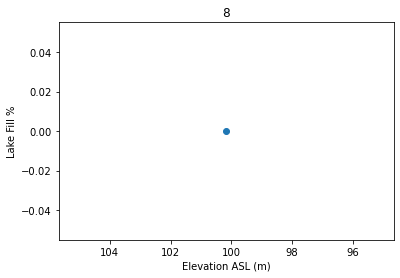

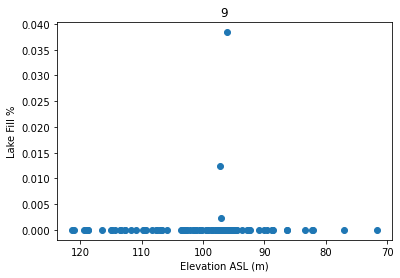

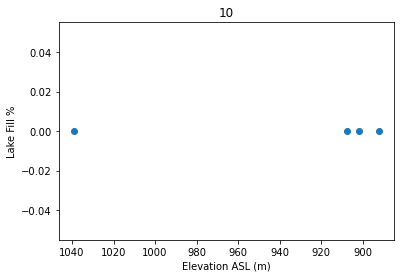

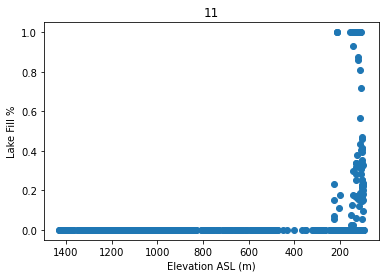

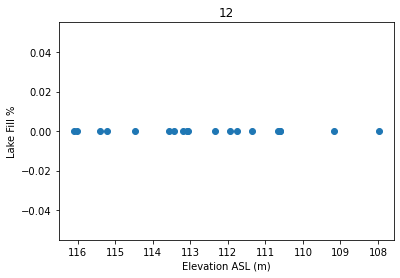

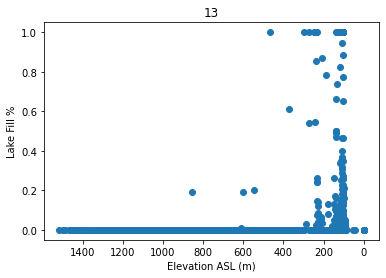

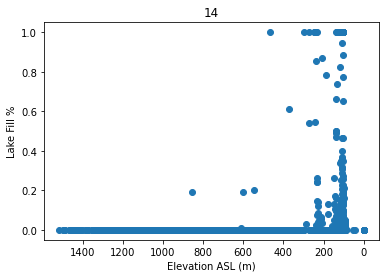

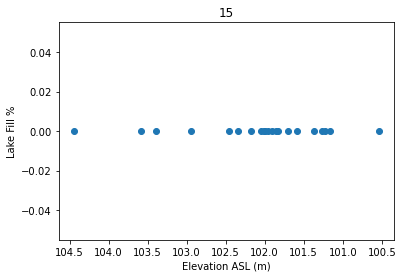

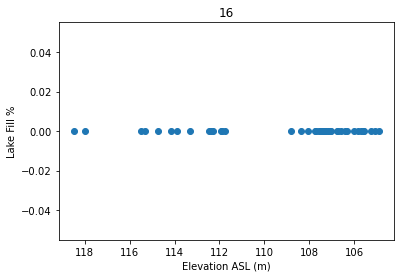

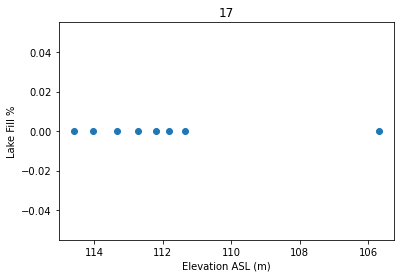

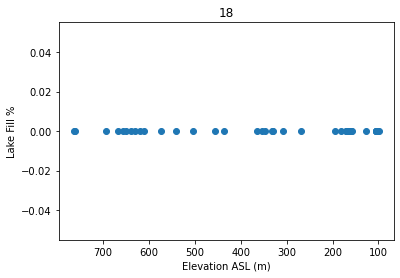

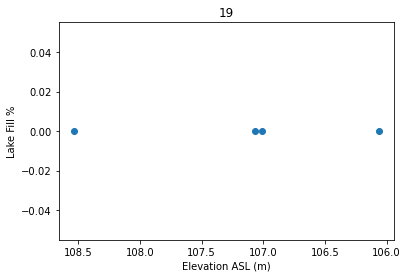

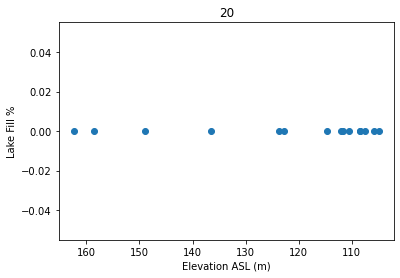

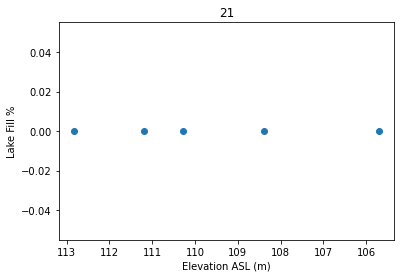

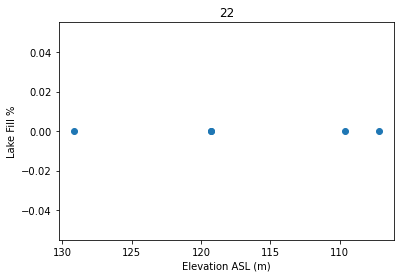

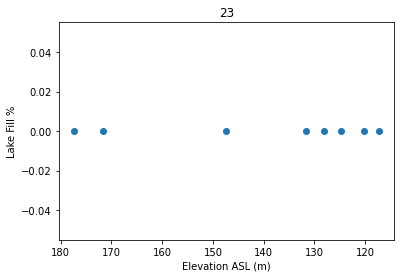

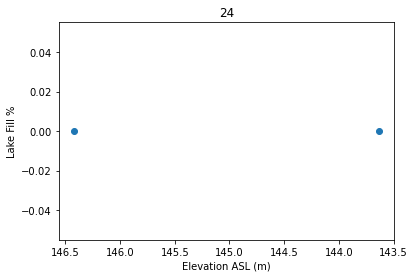

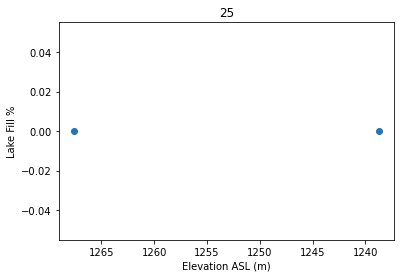

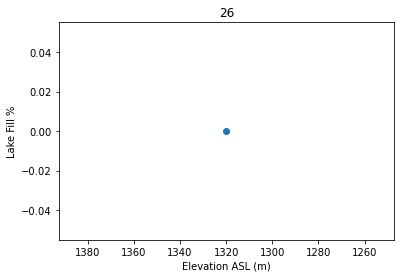

In [585]:
for kk in np.arange(0,numbasins):
    if len(b.LakeFillPercent[kk])>0:
        elevations = np.float_(np.array(b.SubCatchmentMeanElev[kk]))
        elevations = np.nan_to_num(elevations,-9999)
        sortI = np.argsort(elevations,0)
        lake_fill = b.LakeFillPercent[kk]
        if np.any(lake_fill>1):
            lake_fill[lake_fill>1]=1
        sorted_lake_fill = np.squeeze((lake_fill[sortI]).tolist())
        
    plt.figure()
    plt.title(str(kk))
    if np.count_nonzero(elevations)>1:
            plt.scatter(elevations[sortI],sorted_lake_fill)
    else:           
        plt.scatter(elevations,sorted_lake_fill)
    ax = plt.gca()
    ax.invert_xaxis()
    plt.xlabel('Elevation ASL (m)')
    plt.ylabel('Lake Fill %')


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


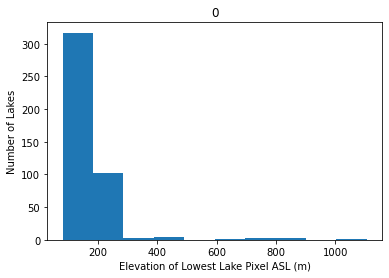

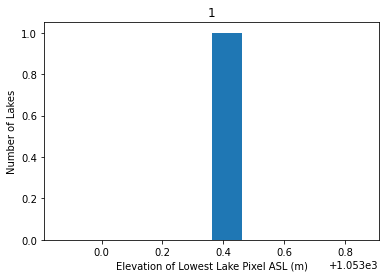

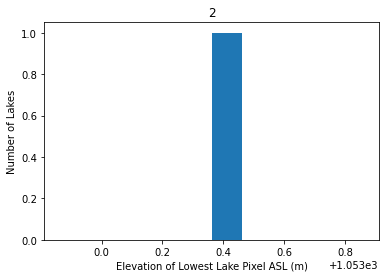

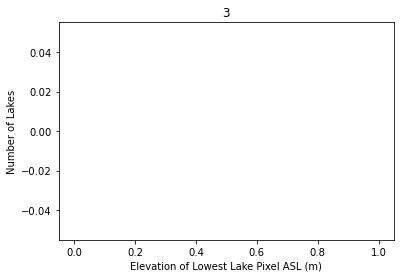

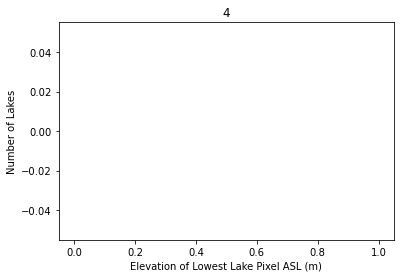

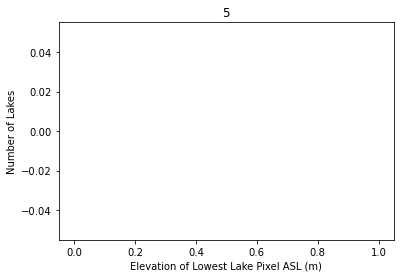

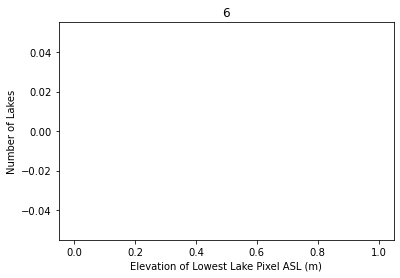

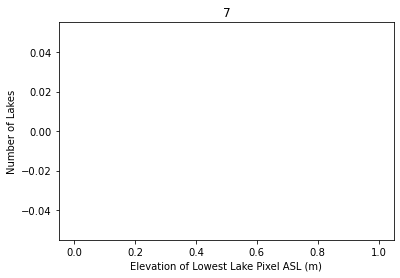

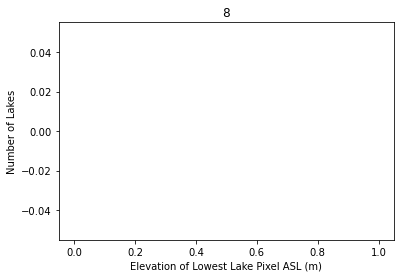

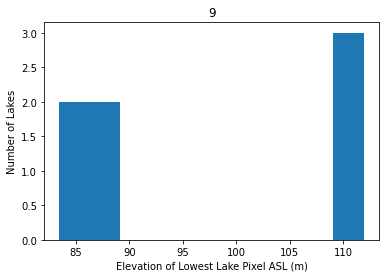

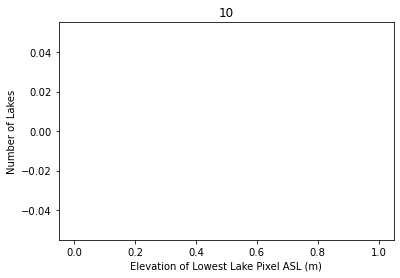

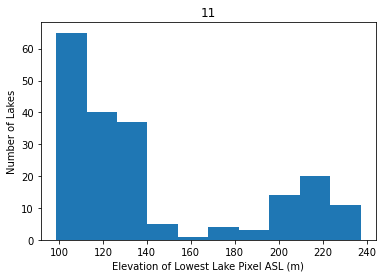

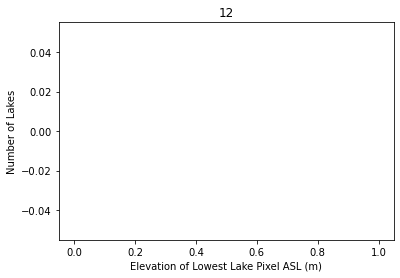

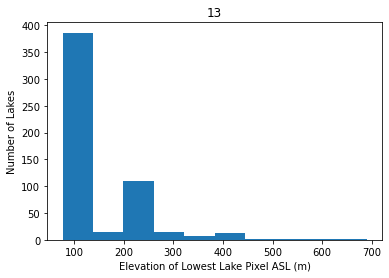

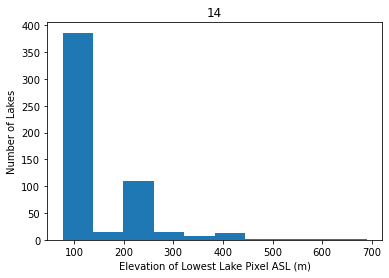

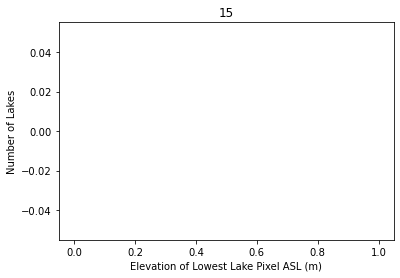

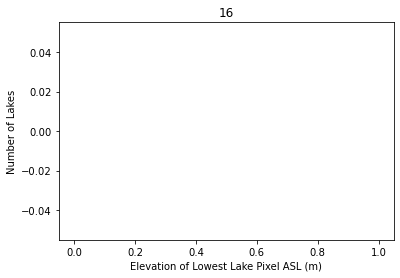

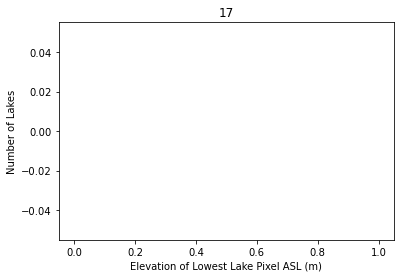

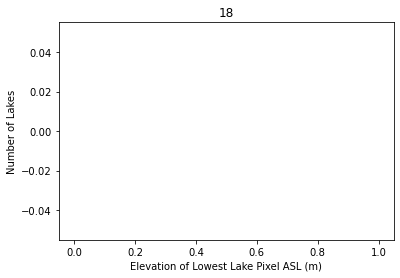

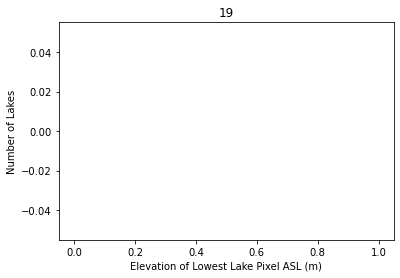

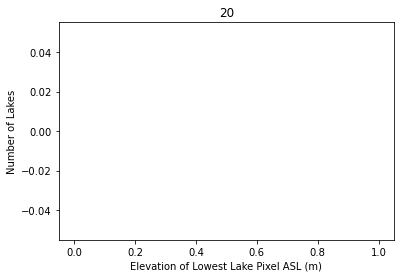

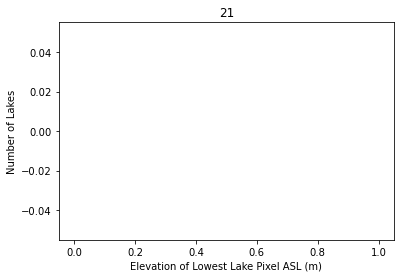

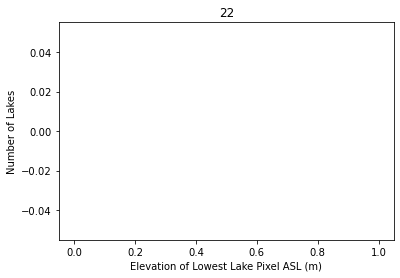

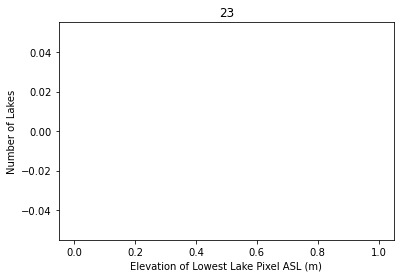

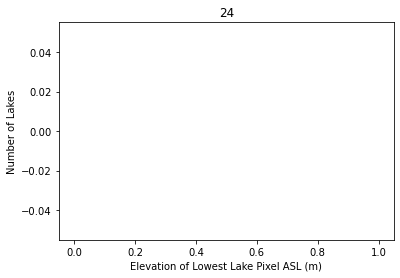

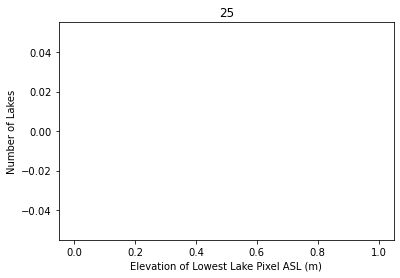

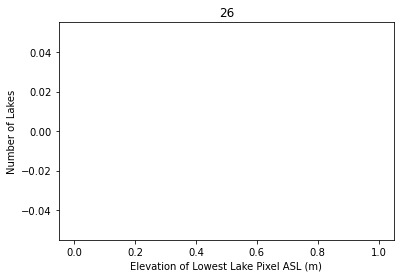

In [587]:
for kk in np.arange(0,numbasins):
    if len(b.LowestLakeElevations[kk])>0:
        elevations = np.float_(np.array(b.SubCatchmentMeanElev[kk]))
        elevations = np.nan_to_num(elevations,-9999)
        sortI = np.argsort(elevations,0)
        lowest_L8_lakes = b.LowestLakeElevations[kk]
        sorted_L8_lakes = np.squeeze((lowest_L8_lakes[sortI]).tolist())

    plt.figure()
    plt.title(str(kk))
          
    plt.hist(sorted_L8_lakes[sorted_L8_lakes>0])
    ax = plt.gca()
    plt.xlabel('Elevation of Lowest Lake Pixel ASL (m)')
    plt.ylabel('Number of Lakes')

Text(0, 0.5, 'Lake Fill %')

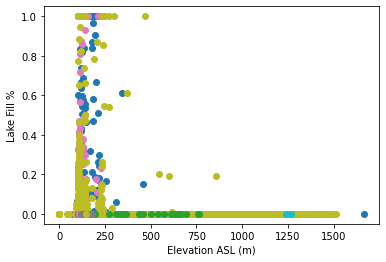

In [588]:
plt.figure()
for kk in np.arange(0,numbasins):
    if len(b.LakeFillPercent[kk])>0:
        elevations = np.float_(np.array(b.SubCatchmentMeanElev[kk]))
        elevations = np.nan_to_num(elevations,-9999)
        sortI = np.argsort(elevations,0)
        percentfill_L8_lakes = b.LakeFillPercent[kk]
        if np.any(percentfill_L8_lakes>1):
            percentfill_L8_lakes[percentfill_L8_lakes>1]=1
        sorted_percentfill = np.squeeze((percentfill_L8_lakes[sortI]).tolist())
        if np.count_nonzero(elevations)>1:
            plt.scatter(elevations[sortI],sorted_percentfill,)
        #else:           
         #   plt.scatter(elevations,sorted_percentfill)
ax = plt.gca()
plt.xlabel('Elevation ASL (m)')
plt.ylabel('Lake Fill %')

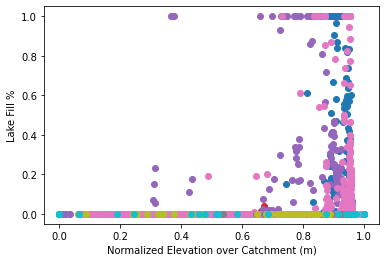

In [595]:
plt.figure()
percentfillbynormelev = pd.DataFrame(columns={'PercentFill','Elevation','BasinNumber'})
for kk in np.arange(0,numbasins):
    Mask = LakeData.REMA_basins.values == b.CatchmentNumber[kk]
    if len(np.argwhere(Mask))>0:
        max_elev = np.nanmax((dem[Mask]).ravel())
        min_elev = np.nanmin((dem[Mask]).ravel())

        
        elevations = np.float_(np.array(b.SubCatchmentMeanElev[kk]))
        elevations = np.nan_to_num(elevations,-9999)
        sortI = np.argsort(elevations,0)
        percentfill_L8_lakes = b.LakeFillPercent[kk]
        if np.any(percentfill_L8_lakes>1):
            percentfill_L8_lakes[percentfill_L8_lakes>1]=1
        sorted_percentfill = np.squeeze((percentfill_L8_lakes[sortI]).tolist())
        normalized_elevations = (elevations - min_elev)/(max_elev-min_elev)
        normalized_elevations = np.squeeze(normalized_elevations.tolist())
        sorted_elevation = normalized_elevations[sortI]
        sorted_elevation[sorted_elevation>1] = 1
        sorted_elevation[sorted_elevation<0] = 0
        plt.scatter(1-sorted_elevation,sorted_percentfill)
    ax = plt.gca()
    plt.xlabel('Normalized Elevation over Catchment (m)')
    plt.ylabel('Lake Fill %')
    data = {'PercentFill':sorted_percentfill,
            'Elevation': 1-np.squeeze(sorted_elevation),
            'BasinNumber': kk*np.ones(sorted_percentfill.shape)}
    add_data = pd.DataFrame(data, columns={'PercentFill','Elevation','BasinNumber'})
    percentfillbynormelev = pd.concat((percentfillbynormelev,add_data), axis=0)
    

In [596]:
percentfillbynormelev

Elevation  BasinNumber  PercentFill
0         1.0          0.0          0.0
1         1.0          0.0          0.0
2         1.0          0.0          0.0
3         1.0          0.0          0.0
4         1.0          0.0          0.0
..        ...          ...          ...
32        0.0         26.0          0.0
33        0.0         26.0          0.0
34        0.0         26.0          0.0
35        0.0         26.0          0.0
36        0.0         26.0          0.0

[17861 rows x 3 columns]

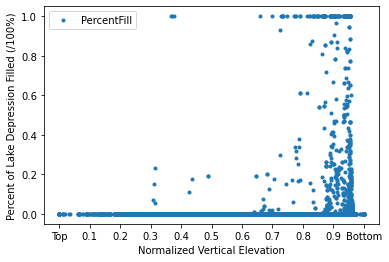

In [597]:
percentfillbynormelev.sort_values(
        'Elevation').plot(x='Elevation',y='PercentFill',marker='.',linestyle='None')
plt.ylabel('Percent of Lake Depression Filled (/100%)')
plt.xlabel('Normalized Vertical Elevation')
plt.xticks(ticks =[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],labels= ['Top',.1,.2,.3,.4,.5,.6,.7,.8,.9,'Bottom']);


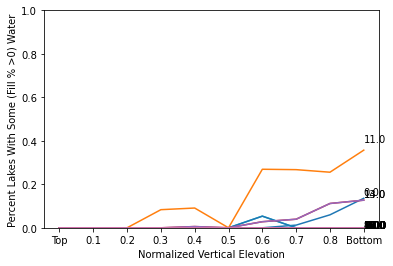

In [610]:
for bn in np.arange(0, percentfillbynormelev.BasinNumber.max()+1):
    elev_bins = pd.IntervalIndex.from_tuples(
            [(i, i+0.1) for i in np.arange(0.,1,0.1)],
            closed="left"
        )
    bin_labels = [f"[{i}, {i+0.1})" for i in np.arange(0,1,0.1)]

    data_binned = pd.cut(
            percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].Elevation,
            elev_bins,
            labels=bin_labels,

        )
    filled = (percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].PercentFill>0).groupby(data_binned).sum()
    total = percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].groupby(data_binned).count().PercentFill

    ratio = filled/total
    ratio = np.nan_to_num(ratio)
    plt.plot([0,1,2,3,4,5,6,7,8,9],ratio)
    plt.ylabel('Percent Lakes With Some (Fill % >0) Water')
    plt.ylim([0,1])
    plt.xlabel('Normalized Vertical Elevation')
    plt.xticks(ticks =[0,1,2,3,4,5,6,7,8,9], labels=['Top',.1,.2,.3,.4,.5,.6,.7,.8,'Bottom'])
    plt.text(9,ratio[-1]*1.1,bn)


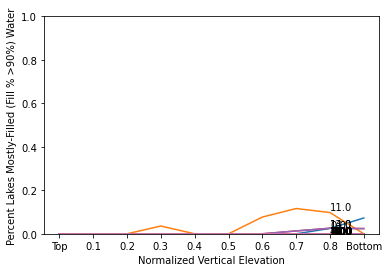

In [599]:
for bn in np.arange(0, percentfillbynormelev.BasinNumber.max()+1):
    elev_bins = pd.IntervalIndex.from_tuples(
            [(i, i+0.1) for i in np.arange(0.,1,0.1)],
            closed="left"
        )
    bin_labels = [f"[{i}, {i+0.1})" for i in np.arange(0,1,0.1)]

    data_binned = pd.cut(
            percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].Elevation,
            elev_bins,
            labels=bin_labels,

        )
    ninetyperc = (percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].PercentFill>.9).groupby(data_binned).sum()
    total = percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].groupby(data_binned).count().PercentFill

    ratio = ninetyperc/total
    ratio = np.nan_to_num(ratio)
    plt.plot([0,1,2,3,4,5,6,7,8,9],ratio)
    plt.ylabel('Percent Lakes Mostly-Filled (Fill % >90%) Water')
    plt.ylim([0,1])
    plt.xlabel('Normalized Vertical Elevation')
    plt.xticks(ticks =[0,1,2,3,4,5,6,7,8,9], labels=['Top',.1,.2,.3,.4,.5,.6,.7,.8,'Bottom'])
    plt.text(8,ratio[-2]*1.1,bn)


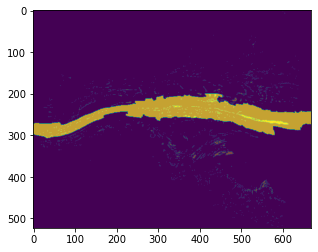

In [601]:
plt.imshow(LakeData.REMA_basins.values==1403)
plt.imshow(L8_lakes,alpha=0.3)

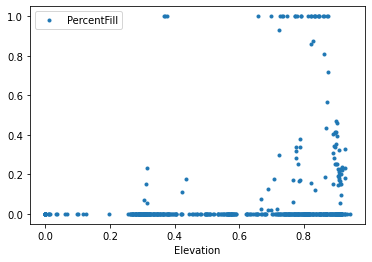

In [606]:
percentfillbynormelev[percentfillbynormelev.BasinNumber==11].plot(x='Elevation',y='PercentFill',
                                                                 marker='.',
                                                                 linestyle='None')

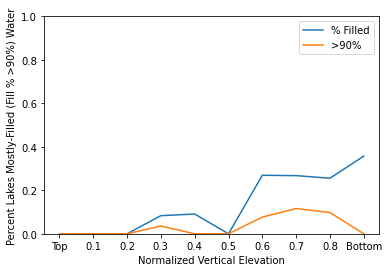

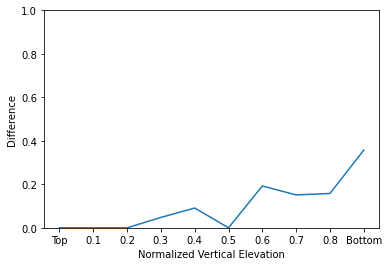

In [616]:
bn=11
elev_bins = pd.IntervalIndex.from_tuples(
        [(i, i+0.1) for i in np.arange(0.,1,0.1)],
        closed="left"
    )
bin_labels = [f"[{i}, {i+0.1})" for i in np.arange(0,1,0.1)]

data_binned = pd.cut(
        percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].Elevation,
        elev_bins,
        labels=bin_labels,

    )
ninetyperc = (percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].PercentFill>.9).groupby(data_binned).sum()
total = percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].groupby(data_binned).count().PercentFill
filled = (percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].PercentFill>0).groupby(data_binned).sum()
total = percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].groupby(data_binned).count().PercentFill

filled_ratio = filled/total
ratio = np.nan_to_num(filled_ratio)
plt.plot([0,1,2,3,4,5,6,7,8,9],filled_ratio)
ninety_ratio = ninetyperc/total
ratio = np.nan_to_num(ninety_ratio)
plt.plot([0,1,2,3,4,5,6,7,8,9],ninety_ratio)
plt.ylabel('Percent Lakes Mostly-Filled (Fill % >90%) Water')
plt.ylim([0,1])
plt.xlabel('Normalized Vertical Elevation')
plt.xticks(ticks =[0,1,2,3,4,5,6,7,8,9], labels=['Top',.1,.2,.3,.4,.5,.6,.7,.8,'Bottom']);
plt.legend(['% Filled', '>90%'])

plt.figure()
plt.plot([0,1,2,3,4,5,6,7,8,9],filled_ratio-ninety_ratio)
plt.ylabel('Difference')
plt.ylim([0,1])
plt.xlabel('Normalized Vertical Elevation')
plt.xticks(ticks =[0,1,2,3,4,5,6,7,8,9], labels=['Top',.1,.2,.3,.4,.5,.6,.7,.8,'Bottom']);

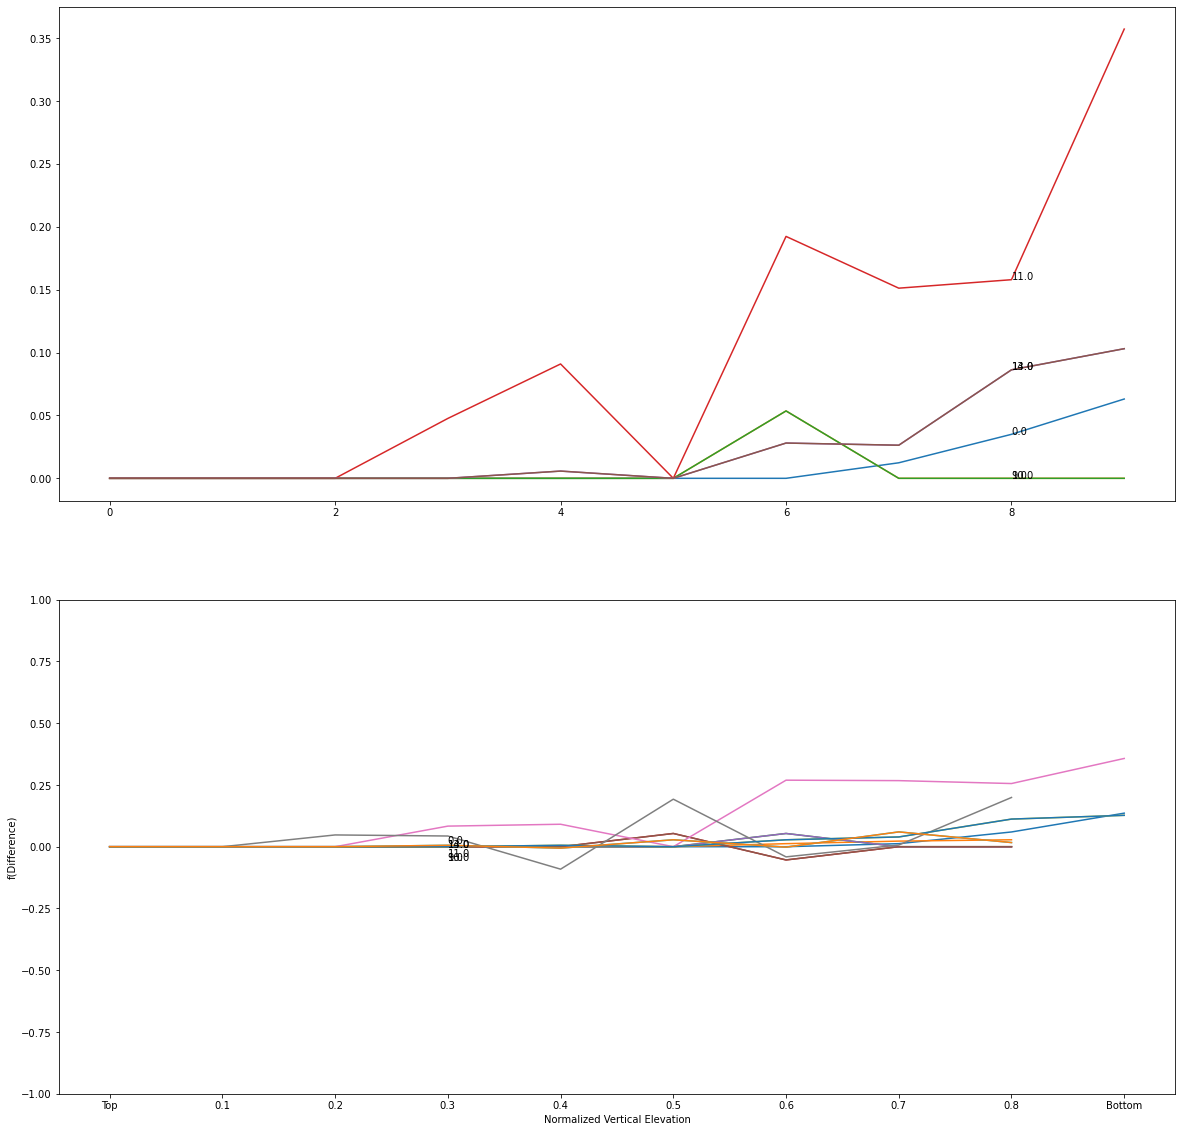

In [645]:
fig, ax = plt.subplots(nrows=2, figsize=(20,20))
for bn in np.arange(0, percentfillbynormelev.BasinNumber.max()+1):
    if np.count_nonzero(percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].PercentFill)>0:
        elev_bins = pd.IntervalIndex.from_tuples(
                [(i, i+0.1) for i in np.arange(0.,1,0.1)],
                closed="left"
            )
        bin_labels = [f"[{i}, {i+0.1})" for i in np.arange(0,1,0.1)]

        data_binned = pd.cut(
                percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].Elevation,
                elev_bins,
                labels=bin_labels,

            )
        ninetyperc = (percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].PercentFill>.9).groupby(data_binned).sum()
        total = percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].groupby(data_binned).count().PercentFill
        filled = (percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].PercentFill>0).groupby(data_binned).sum()
        total = percentfillbynormelev[percentfillbynormelev.BasinNumber==bn].groupby(data_binned).count().PercentFill

        filled_ratio = filled/total
        ratio = np.nan_to_num(filled_ratio)
        plt.plot([0,1,2,3,4,5,6,7,8,9],filled_ratio)
        ninety_ratio = ninetyperc/total
        ninety_ratio = np.nan_to_num(ninety_ratio)
    
        difference = filled_ratio-ninety_ratio
        ax[0].plot([0,1,2,3,4,5,6,7,8,9],np.nan_to_num(difference))
        plt.ylabel('Difference')
        plt.ylim([0,1])
        plt.xlabel('Normalized Vertical Elevation')
        plt.xticks(ticks =[0,1,2,3,4,5,6,7,8,9], labels=['Top',.1,.2,.3,.4,.5,.6,.7,.8,'Bottom']);
        ax[0].text(8,difference[-2],bn)

        diffdifference = np.diff(difference)
        ax[1].plot(np.nan_to_num(diffdifference))
        plt.ylabel('f(Difference)')
        plt.ylim([-1,1])
        plt.xlabel('Normalized Vertical Elevation')
        plt.xticks(ticks =[0,1,2,3,4,5,6,7,8,9], labels=['Top',.1,.2,.3,.4,.5,.6,.7,.8,'Bottom']);
        ax[1].text(3,diffdifference[-3],bn)
